# Klein Bottle from the Insurance Outcome Manifold

## Hypothesis

The mapping from **tower configuration** `(deductible, max_limit)` to **economic outcomes**
`(growth_rate, growth_volatility, premium)` defines a 2D surface embedded in 3D outcome space.

Different tower configurations can produce identical economic outcomes — a high-deductible/high-limit
tower (retain small losses, transfer catastrophic) may match a low-deductible/low-limit tower
(transfer small losses, cap catastrophic coverage) in all three output dimensions.

Where these strategy-equivalent points overlap, the surface **self-intersects**. If the
self-intersection has the right topology (orientation-reversing), the result is a **Klein Bottle**.

### The Two Paths to No Insurance

The surface has a natural boundary along the diagonal `ded = max_limit` (zero coverage width).
Approaching this boundary from two directions:
- **Bottom-up**: raise deductible with limit fixed (peel coverage from below)
- **Top-down**: lower max_limit with ded fixed (peel coverage from above)

Both converge to the uninsured outcome, but the growth rate gradient may point in opposite
directions along these two edges — an orientation reversal that produces Klein Bottle topology.

In [1]:
"""Google Colab setup: mount Drive and install package dependencies."""
import sys, os
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    NOTEBOOK_DIR = '/content/drive/My Drive/Colab Notebooks/ei_notebooks/research'
    os.chdir(NOTEBOOK_DIR)
    if NOTEBOOK_DIR not in sys.path:
        sys.path.append(NOTEBOOK_DIR)
    !pip install ergodic-insurance -q 2>&1 | tail -3
    print('\nSetup complete.')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.ticker as mticker
from scipy.interpolate import PchipInterpolator, RegularGridInterpolator
import warnings, logging, time, multiprocessing, itertools

warnings.filterwarnings("ignore")
logging.getLogger("ergodic_insurance").setLevel(logging.ERROR)

from ergodic_insurance.insurance_program import EnhancedInsuranceLayer, InsuranceProgram
from ergodic_insurance.loss_distributions import ManufacturingLossGenerator, LognormalLoss, ParetoLoss
from ergodic_insurance.insurance_pricing import LayerPricer

plt.style.use("seaborn-v0_8-darkgrid")
SEED = 42
np.random.seed(SEED)
N_CORES = multiprocessing.cpu_count()
print(f"Cores: {N_CORES}")

Cores: 16


## Shared Simulation Infrastructure

Loss model, analytical LEV-based layer pricing, tower factory, and CRN engine.
Compact version of the infrastructure from `optimization/09_tower_demand_curve.ipynb`.

In [3]:
# === Economic Parameters ===
ATR = 2.0
OPERATING_MARGIN = 0.15
REV_VOL = 0.50
INITIAL_ASSETS = 5_000_000
REFERENCE_REVENUE = ATR * INITIAL_ASSETS
FREQ_SCALING_EXPONENT = 0.75

# === Loss Model ===
ATTR_BASE_FREQ, ATTR_SEV_MEAN, ATTR_SEV_CV = 5, 10_000, 10
LG_BASE_FREQ, LG_SEV_MEAN, LG_SEV_CV = 1.75, 400_000, 5
CAT_BASE_FREQ, CAT_SEV_ALPHA, CAT_SEV_XM = 0.25, 2.01, 800_000

LOSS_PARAMS = dict(
    attritional_params={'base_frequency': ATTR_BASE_FREQ, 'severity_mean': ATTR_SEV_MEAN,
                        'severity_cv': ATTR_SEV_CV, 'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                        'reference_revenue': REFERENCE_REVENUE},
    large_params={'base_frequency': LG_BASE_FREQ, 'severity_mean': LG_SEV_MEAN,
                  'severity_cv': LG_SEV_CV, 'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                  'reference_revenue': REFERENCE_REVENUE},
    catastrophic_params={'base_frequency': CAT_BASE_FREQ, 'severity_alpha': CAT_SEV_ALPHA,
                         'severity_xm': CAT_SEV_XM, 'revenue_scaling_exponent': FREQ_SCALING_EXPONENT,
                         'reference_revenue': REFERENCE_REVENUE},
)

# === Layer Pricing ===
MIN_LAYER_MIDPOINT = np.mean([0, 5_000_000])
MAX_LAYER_MIDPOINT = np.mean([450_000_000, 500_000_000])

def make_layer_pricers(cur_revenue=REFERENCE_REVENUE):
    scale = (cur_revenue / REFERENCE_REVENUE) ** FREQ_SCALING_EXPONENT
    return (
        LayerPricer(LognormalLoss(mean=ATTR_SEV_MEAN, cv=ATTR_SEV_CV), frequency=ATTR_BASE_FREQ * scale),
        LayerPricer(LognormalLoss(mean=LG_SEV_MEAN, cv=LG_SEV_CV), frequency=LG_BASE_FREQ * scale),
        LayerPricer(ParetoLoss(alpha=CAT_SEV_ALPHA, xm=CAT_SEV_XM), frequency=CAT_BASE_FREQ * scale),
    )

DEFAULT_PRICERS = make_layer_pricers()

def analytical_layer_premium(attachment, limit, base_loss_ratio, loss_ratio_inflection, pricers=None):
    pricers = pricers or DEFAULT_PRICERS
    expected_loss = sum(p.expected_layer_loss(attachment, limit) for p in pricers)
    midpoint = np.mean([attachment, attachment + limit])
    layer_lr = base_loss_ratio + (1.0 / loss_ratio_inflection - 1.0) * base_loss_ratio \
               * (midpoint - MIN_LAYER_MIDPOINT) / (MAX_LAYER_MIDPOINT - MIN_LAYER_MIDPOINT)
    return expected_loss / layer_lr

def analytical_rate_on_line(attachment, limit, base_loss_ratio, loss_ratio_inflection, pricers=None):
    if limit <= 0: return 0.0
    return analytical_layer_premium(attachment, limit, base_loss_ratio, loss_ratio_inflection, pricers) / limit

# === Tower Factory (with layer truncation) ===
LAYER_DEFS = [(0, 5e6), (5e6, 10e6), (10e6, 25e6), (25e6, 50e6), (50e6, 100e6),
              (100e6, 150e6), (150e6, 200e6), (200e6, 250e6), (250e6, 300e6),
              (300e6, 350e6), (350e6, 400e6), (400e6, 450e6), (450e6, 500e6)]

def make_program(ded, base_loss_ratio, loss_ratio_inflection, max_limit=None, pricers=None):
    layers = []
    for attach, ceiling in LAYER_DEFS:
        if ded >= ceiling: continue
        if max_limit is not None and max_limit <= attach: continue
        eff_attach = max(attach, ded)
        eff_ceil = min(ceiling, max_limit) if max_limit is not None else ceiling
        limit = eff_ceil - eff_attach
        if limit <= 0: continue
        rol = analytical_rate_on_line(eff_attach, limit, base_loss_ratio, loss_ratio_inflection, pricers)
        layers.append(EnhancedInsuranceLayer(attachment_point=eff_attach, limit=limit,
                                              base_premium_rate=rol, reinstatements=0))
    return InsuranceProgram(layers=layers, deductible=ded,
                            name=f"Tower Ded=${ded:,.0f} Lim=${max_limit:,.0f}" if max_limit else f"Tower Ded=${ded:,.0f}")

# === CRN Loss Pool ===
def generate_loss_pool(n_paths, n_years, reference_revenue=REFERENCE_REVENUE, seed=SEED):
    ss = np.random.SeedSequence(seed)
    children = ss.spawn(n_paths + 1)
    rev_rng = np.random.default_rng(children[0])
    revenue_shocks = rev_rng.standard_normal((n_paths, n_years))
    all_losses = []
    for i in range(n_paths):
        gen = ManufacturingLossGenerator(**LOSS_PARAMS,
              seed=int(children[i + 1].generate_state(1)[0] % (2**31)))
        path_losses = []
        for t in range(n_years):
            events, _ = gen.generate_losses(duration=1.0, revenue=reference_revenue)
            path_losses.append(events)
        all_losses.append(path_losses)
    return revenue_shocks, all_losses

print("Infrastructure loaded.")

Infrastructure loaded.


## Experiment: Map (ded, max_limit) to Outcome Space

Fix one market scenario `(revenue=$5M, base_loss_ratio=0.70, inflection=1.0)`.
Sweep a grid of `(ded, max_limit)` pairs, simulate 500 CRN paths for each,
and record `(growth_rate, growth_vol, premium)`.

The resulting parametric surface in 3D outcome space is the **outcome manifold** of
the insurance tower configuration space.

In [4]:
# === Experiment Parameters ===
SLICE_REVENUE = 5_000_000
SLICE_LR = 0.70
SLICE_INFLECTION = 1.0
N_SIM = 500  # paths per (ded, max_limit) combo

# Coarse grids for the 2D sweep
ded_grid = np.unique(np.concatenate([
    [0, 25_000, 50_000, 100_000, 250_000, 500_000, 750_000,
     1_000_000, 1_500_000, 2_000_000, 3_000_000, 5_000_000,
     7_500_000, 10_000_000, 15_000_000, 25_000_000, 50_000_000],
    np.geomspace(50_000_000, 200_000_000, 10)[1:],
]))

ml_grid = np.unique(np.concatenate([
    [500_000, 1_000_000, 2_000_000, 5_000_000, 10_000_000,
     25_000_000, 50_000_000, 100_000_000, 200_000_000, 500_000_000],
    np.geomspace(1_000_000, 500_000_000, 20),
]))

initial_assets = SLICE_REVENUE / ATR

print(f"Slice: revenue=${SLICE_REVENUE/1e6:.0f}M, LR={SLICE_LR:.0%}, inflection={SLICE_INFLECTION:.0f}x")
print(f"Grid: {len(ded_grid)} ded x {len(ml_grid)} max_limit")

# Generate CRN pool at this revenue
shocks, losses = generate_loss_pool(n_paths=N_SIM, n_years=1,
                                     reference_revenue=SLICE_REVENUE, seed=SEED)
pricers = make_layer_pricers(cur_revenue=SLICE_REVENUE)

# === Sweep all (ded, max_limit) combos ===
records = []
t0 = time.time()
n_total = sum(1 for d in ded_grid for m in ml_grid if d < m)
n_done = 0

for ded in ded_grid:
    for ml in ml_grid:
        if ded >= ml:
            continue

        program = make_program(ded, SLICE_LR, SLICE_INFLECTION, max_limit=ml, pricers=pricers)
        premium = program.calculate_premium()
        has_layers = len(program.layers) > 0

        W_T = np.empty(N_SIM)
        for i in range(N_SIM):
            assets = initial_assets
            rev = assets * ATR * np.exp(REV_VOL * shocks[i, 0] - 0.5 * REV_VOL**2)
            op_income = rev * OPERATING_MARGIN
            loss_scale = (rev / SLICE_REVENUE) ** FREQ_SCALING_EXPONENT

            total_retained = 0.0
            if has_layers:
                prog = InsuranceProgram.create_fresh(program)
                for event in losses[i][0]:
                    scaled = event.amount * loss_scale
                    result = prog.process_claim(scaled)
                    total_retained += result.deductible_paid + result.uncovered_loss
            else:
                for event in losses[i][0]:
                    total_retained += event.amount * loss_scale

            assets += op_income - total_retained - premium
            W_T[i] = max(assets, 0.0)

        log_g = np.log(np.maximum(W_T, 1.0) / initial_assets)
        records.append({
            'ded': ded, 'max_limit': ml,
            'log_ded': np.log10(max(ded, 1)),
            'log_ml': np.log10(ml),
            'growth_rate': np.mean(log_g),
            'growth_vol': np.std(log_g),
            'ruin_prob': np.mean(W_T <= 0),
            'premium': premium,
            'mean_wealth': np.mean(W_T),
            'tower_width': ml - ded,
        })
        n_done += 1

elapsed = time.time() - t0
df_surface = pd.DataFrame(records)
print(f"\nDone: {len(df_surface)} combos in {elapsed:.1f}s")
print(f"Growth rate range: [{df_surface['growth_rate'].min():.4f}, {df_surface['growth_rate'].max():.4f}]")
print(f"Growth vol range:  [{df_surface['growth_vol'].min():.4f}, {df_surface['growth_vol'].max():.4f}]")
print(f"Premium range:     [${df_surface['premium'].min():,.0f}, ${df_surface['premium'].max():,.0f}]")

Slice: revenue=$5M, LR=70%, inflection=1x
Grid: 26 ded x 28 max_limit

Done: 441 combos in 29.0s
Growth rate range: [-0.7798, -0.0370]
Growth vol range:  [0.1474, 3.4217]
Premium range:     [$201, $974,681]


## 3D Parametric Surface: Outcome Manifold

Plot the surface `(ded, max_limit) -> (growth_rate, growth_vol, premium)` in 3D.
Each point on the surface represents the economic outcome of one tower configuration.
Where the surface folds over itself, two different towers produce the same outcome.

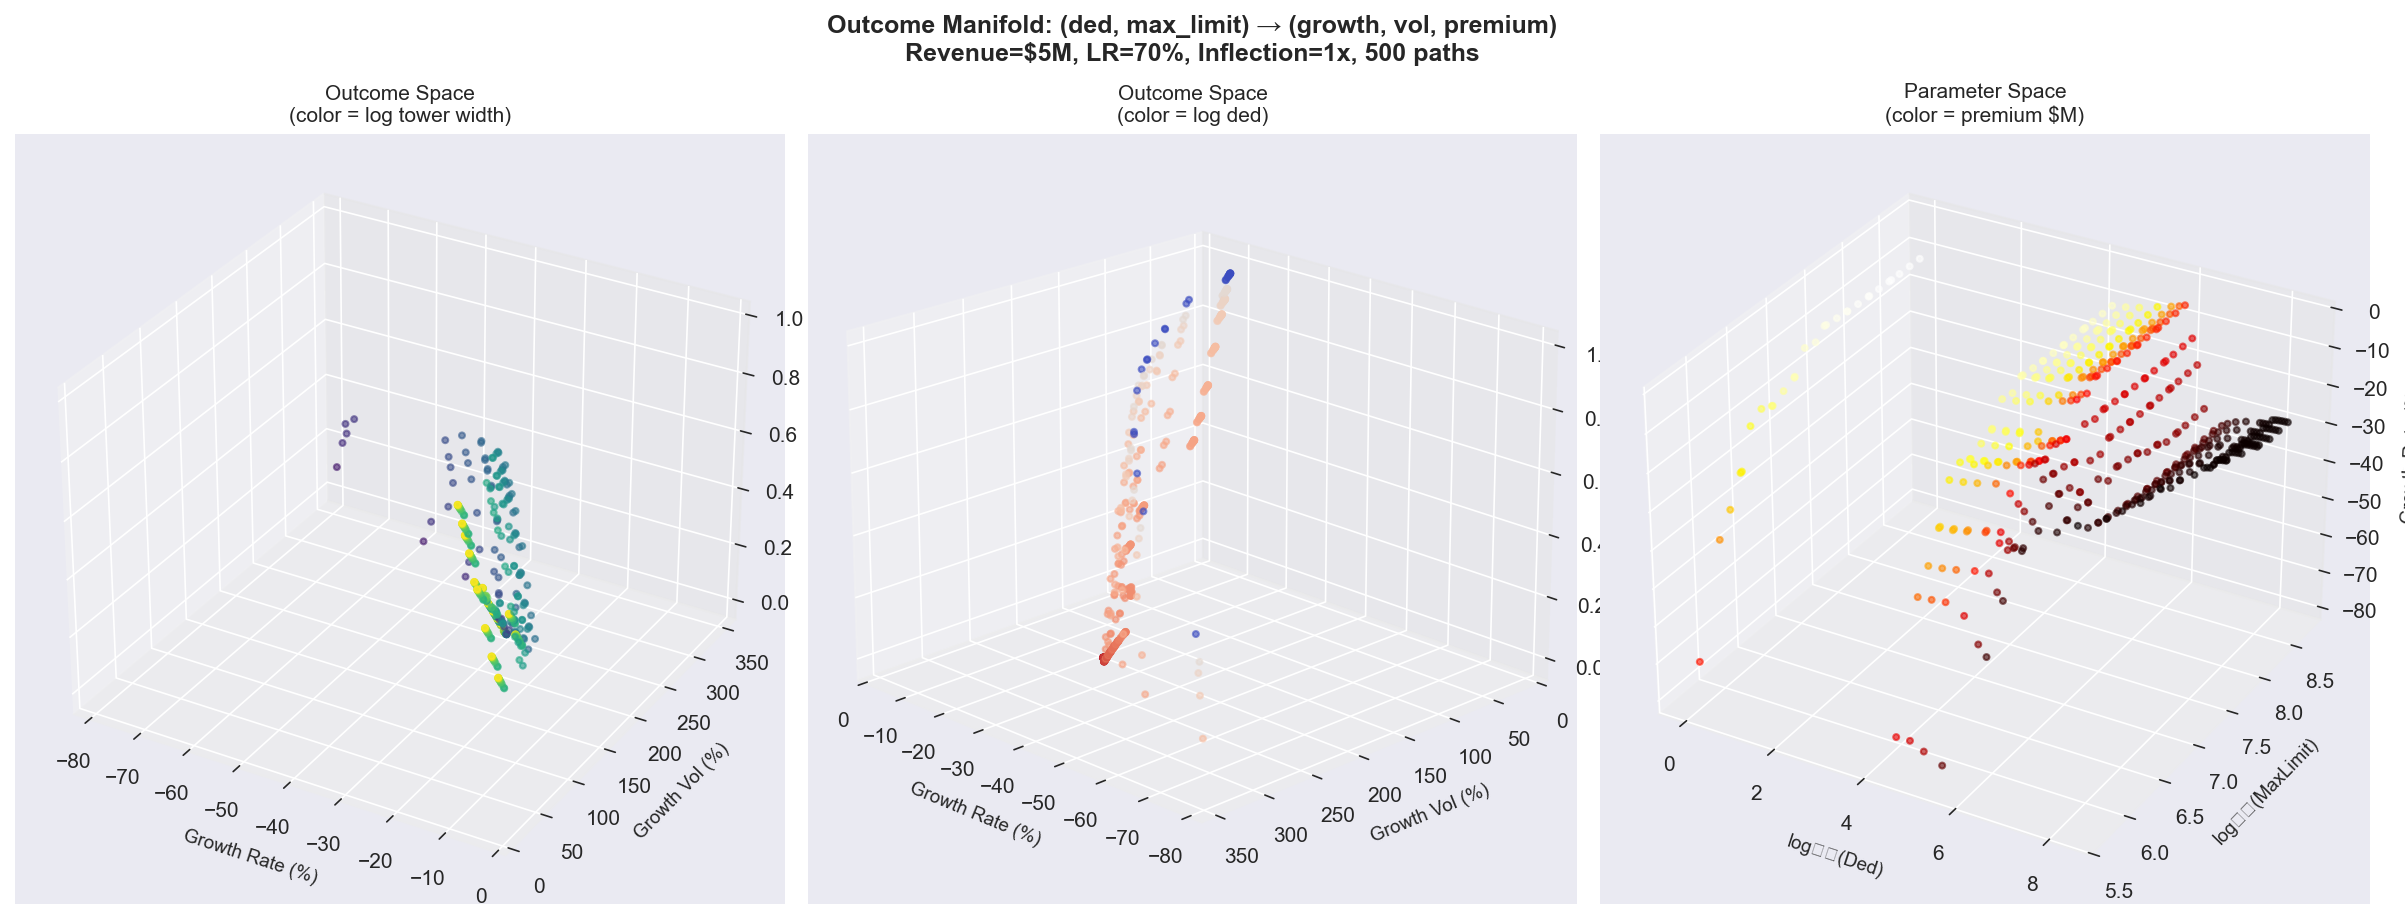

Saved: klein_bottle_manifold_scatter.png


In [5]:
# === 3D Parametric Surface Plot ===

from scipy.interpolate import griddata

# The parametric surface maps (log_ded, log_ml) -> (growth_rate, growth_vol, premium)
x_param = df_surface['log_ded'].values
y_param = df_surface['log_ml'].values
growth = df_surface['growth_rate'].values
vol = df_surface['growth_vol'].values
prem = df_surface['premium'].values

# --- Plot 1: Scatter in outcome space, colored by tower width ---
fig = plt.figure(figsize=(16, 6), dpi=150)

# Panel A: Outcome space (growth, vol, premium) colored by log(tower_width)
ax1 = fig.add_subplot(131, projection='3d')
width_color = np.log10(np.maximum(df_surface['tower_width'].values, 1))
sc1 = ax1.scatter(growth * 100, vol * 100, prem / 1e6,
                  c=width_color, cmap='viridis', s=8, alpha=0.6)
ax1.set_xlabel('Growth Rate (%)', fontsize=9)
ax1.set_ylabel('Growth Vol (%)', fontsize=9)
ax1.set_zlabel('Premium ($M)', fontsize=9)
ax1.set_title('Outcome Space\n(color = log tower width)', fontsize=10)

# Panel B: Same data, different view angle to reveal folding
ax2 = fig.add_subplot(132, projection='3d')
sc2 = ax2.scatter(growth * 100, vol * 100, prem / 1e6,
                  c=x_param, cmap='coolwarm', s=8, alpha=0.6)
ax2.set_xlabel('Growth Rate (%)', fontsize=9)
ax2.set_ylabel('Growth Vol (%)', fontsize=9)
ax2.set_zlabel('Premium ($M)', fontsize=9)
ax2.set_title('Outcome Space\n(color = log ded)', fontsize=10)
ax2.view_init(elev=20, azim=135)

# Panel C: Parameter space colored by growth rate
ax3 = fig.add_subplot(133, projection='3d')
sc3 = ax3.scatter(x_param, y_param, growth * 100,
                  c=prem / 1e6, cmap='hot', s=8, alpha=0.6)
ax3.set_xlabel('log₁₀(Ded)', fontsize=9)
ax3.set_ylabel('log₁₀(MaxLimit)', fontsize=9)
ax3.set_zlabel('Growth Rate (%)', fontsize=9)
ax3.set_title('Parameter Space\n(color = premium $M)', fontsize=10)

fig.suptitle('Outcome Manifold: (ded, max_limit) → (growth, vol, premium)\n'
             f'Revenue=${SLICE_REVENUE/1e6:.0f}M, LR={SLICE_LR:.0%}, '
             f'Inflection={SLICE_INFLECTION:.0f}x, {N_SIM} paths',
             fontsize=12, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('klein_bottle_manifold_scatter.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("Saved: klein_bottle_manifold_scatter.png")

## Self-Intersection Analysis

Two different `(ded, max_limit)` pairs self-intersect in outcome space when they produce
nearly identical `(growth_rate, growth_vol, premium)` triples. We search for such pairs
and check whether they approach from opposite orientations.

Found 7570 pairs within 5% threshold in outcome space

Self-intersection candidates (far in param space, near in outcome space): 1483

Top 10 closest self-intersections:
  Tower A: Ded=$ 15,000,000  Lim=$ 18,987,137  g=-0.3034  vol=2.3841  prem=$   10,544
  Tower B: Ded=$ 50,000,000  Lim=$200,000,000  g=-0.3034  vol=2.3841  prem=$   10,546
  Param dist: 1.15  Outcome dist: 0.0000

  Tower A: Ded=$ 25,000,000  Lim=$ 26,333,618  g=-0.2831  vol=2.3111  prem=$    1,598
  Tower B: Ded=$125,992,105  Lim=$187,420,394  g=-0.2831  vol=2.3111  prem=$    1,567
  Param dist: 1.10  Outcome dist: 0.0000

  Tower A: Ded=$ 25,000,000  Lim=$ 26,333,618  g=-0.2831  vol=2.3111  prem=$    1,598
  Tower B: Ded=$146,973,449  Lim=$259,936,878  g=-0.2831  vol=2.3112  prem=$    1,637
  Param dist: 1.26  Outcome dist: 0.0001

  Tower A: Ded=$ 25,000,000  Lim=$ 26,333,618  g=-0.2831  vol=2.3111  prem=$    1,598
  Tower B: Ded=$171,448,797  Lim=$360,511,358  g=-0.2830  vol=2.3111  prem=$    1,547
  Param dist: 1.

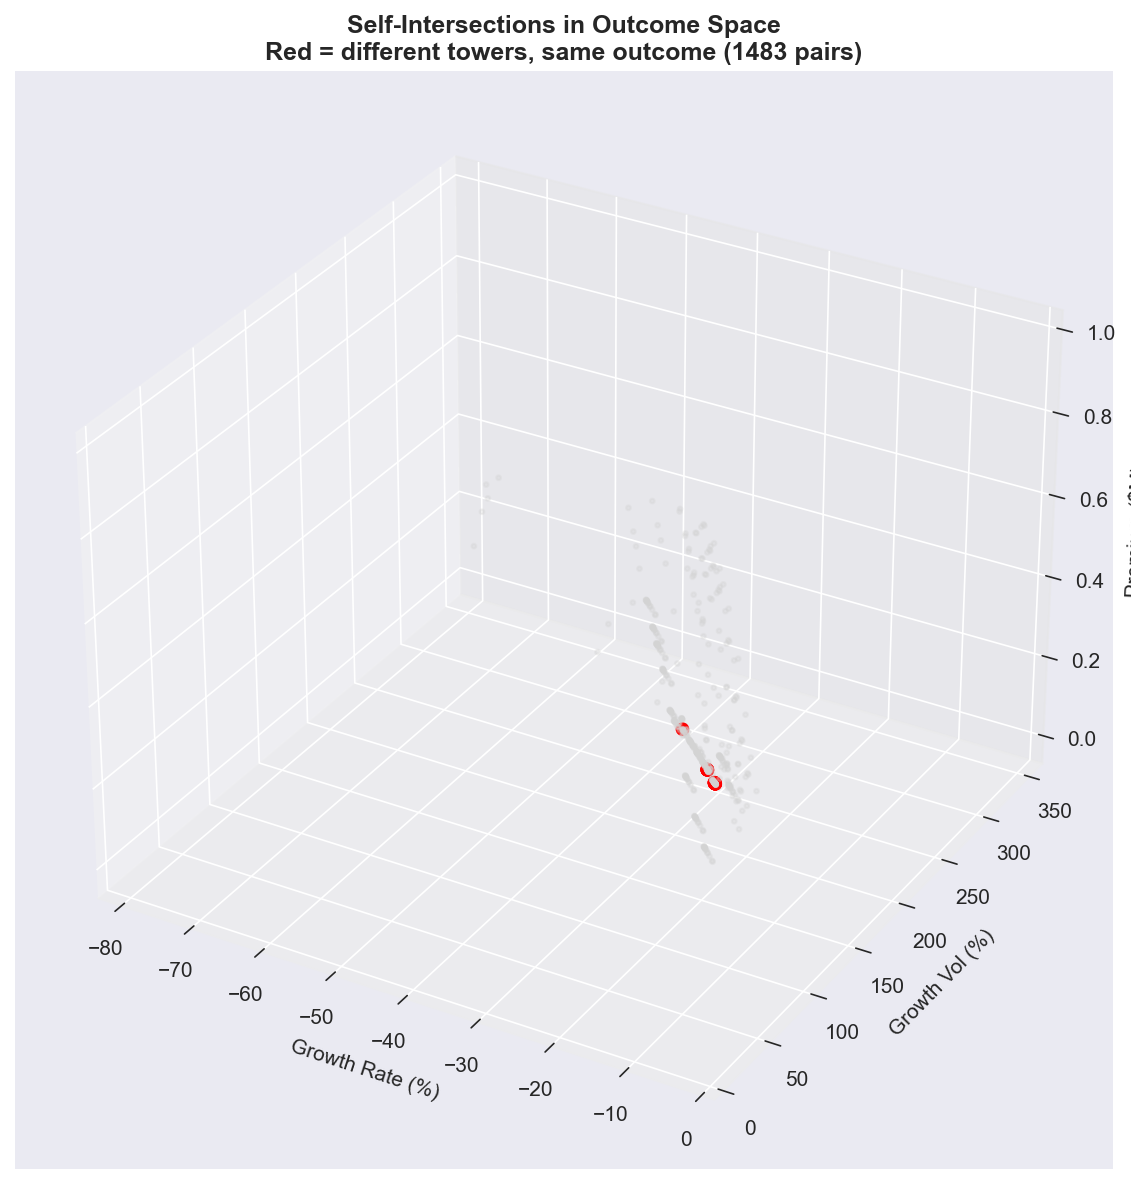

In [6]:
# === Self-Intersection Detection ===
from scipy.spatial import KDTree

# Normalize outcome dimensions to comparable scales
g_range = growth.max() - growth.min()
v_range = vol.max() - vol.min()
p_range = prem.max() - prem.min()

outcome_normalized = np.column_stack([
    (growth - growth.min()) / max(g_range, 1e-12),
    (vol - vol.min()) / max(v_range, 1e-12),
    (prem - prem.min()) / max(p_range, 1e-12),
])

# Build KD-tree and find pairs of points close in outcome space
tree = KDTree(outcome_normalized)
threshold = 0.05  # 5% of range in each dimension

# Find all pairs within threshold
pairs = tree.query_pairs(r=threshold)
print(f"Found {len(pairs)} pairs within {threshold:.0%} threshold in outcome space")

# Filter to pairs that are FAR in parameter space (different towers, same outcome)
param_space = np.column_stack([x_param, y_param])
near_outcome_far_param = []
for i, j in pairs:
    param_dist = np.linalg.norm(param_space[i] - param_space[j])
    if param_dist > 1.0:  # at least 1 order of magnitude apart in either ded or ml
        outcome_dist = np.linalg.norm(outcome_normalized[i] - outcome_normalized[j])
        near_outcome_far_param.append({
            'i': i, 'j': j,
            'ded_i': df_surface.iloc[i]['ded'], 'ml_i': df_surface.iloc[i]['max_limit'],
            'ded_j': df_surface.iloc[j]['ded'], 'ml_j': df_surface.iloc[j]['max_limit'],
            'growth_i': growth[i], 'growth_j': growth[j],
            'vol_i': vol[i], 'vol_j': vol[j],
            'prem_i': prem[i], 'prem_j': prem[j],
            'param_dist': param_dist,
            'outcome_dist': outcome_dist,
        })

df_intersections = pd.DataFrame(near_outcome_far_param)
print(f"\nSelf-intersection candidates (far in param space, near in outcome space): {len(df_intersections)}")

if len(df_intersections) > 0:
    df_intersections = df_intersections.sort_values('outcome_dist')
    print("\nTop 10 closest self-intersections:")
    for _, row in df_intersections.head(10).iterrows():
        print(f"  Tower A: Ded=${row['ded_i']:>11,.0f}  Lim=${row['ml_i']:>11,.0f}  "
              f"g={row['growth_i']:+.4f}  vol={row['vol_i']:.4f}  prem=${row['prem_i']:>9,.0f}")
        print(f"  Tower B: Ded=${row['ded_j']:>11,.0f}  Lim=${row['ml_j']:>11,.0f}  "
              f"g={row['growth_j']:+.4f}  vol={row['vol_j']:.4f}  prem=${row['prem_j']:>9,.0f}")
        print(f"  Param dist: {row['param_dist']:.2f}  Outcome dist: {row['outcome_dist']:.4f}")
        print()

    # Highlight intersections on the 3D plot
    fig = plt.figure(figsize=(10, 8), dpi=150)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(growth * 100, vol * 100, prem / 1e6,
               c='lightgray', s=5, alpha=0.3, label='All towers')

    # Plot intersection pairs
    for _, row in df_intersections.head(20).iterrows():
        i, j = int(row['i']), int(row['j'])
        ax.plot([growth[i]*100, growth[j]*100],
                [vol[i]*100, vol[j]*100],
                [prem[i]/1e6, prem[j]/1e6],
                'r-', linewidth=1, alpha=0.5)
        ax.scatter([growth[i]*100, growth[j]*100],
                   [vol[i]*100, vol[j]*100],
                   [prem[i]/1e6, prem[j]/1e6],
                   c='red', s=30, zorder=5)

    ax.set_xlabel('Growth Rate (%)')
    ax.set_ylabel('Growth Vol (%)')
    ax.set_zlabel('Premium ($M)')
    ax.set_title('Self-Intersections in Outcome Space\n'
                 f'Red = different towers, same outcome ({len(df_intersections)} pairs)',
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.savefig('klein_bottle_manifold_intersections.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("\nNo self-intersections found at this threshold.")
    print("Try: increase grid density, change slice parameters, or relax threshold.")